# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [46]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 43.6 s, sys: 20.6 s, total: 1min 4s
Wall time: 14min 2s


In [ ]:
azdias.iloc[:,[18,19]].columns

In [47]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
customers.iloc[:,[18,19]].columns

In [2]:
attr_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
attribute_desc = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

### Exploratory Analysis

It appears columns 18, and 19 have mixed data types which we will look into if they are not initially dropped due to also having a lack of data.

In [72]:
print(f'Azdias Number of Rows: {azdias.shape[0]}')
print(f'Azdias Number of Columns: {azdias.shape[1]}')
print(f'Customers Number of Rows: {customers.shape[0]}')
print(f'Customers Number of Columns: {customers.shape[1]}')

Azdias Number of Rows: 891221
Azdias Number of Columns: 366
Customers Number of Rows: 191652
Customers Number of Columns: 369


In [76]:
print(f'Size of Customer df compared to Azdias: {int(customers.size/azdias.size*100)}%')

Size of Customer df compared to Azdias: 21%


In [79]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### Replacing unknown values to np.nan

Looking at the DIAS Attributes excel file we can see Attributes typically have a value they use for any unknowns. This can differ depending on the attribute so we'll need to bind these unknown values to their corrosponding attribute by creating a dict, and then mapping this to the DataFrames, replacing them with np.nan.

In [148]:
attr_values.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [120]:
def replace_value_with_nans(df):
    """
    Changes values in the dataframe to np.nan, that correspond
    to unknown values in the attributes excel file.

    Attr (dataframe): Original DataFrame
    Returns: Processed DataFrame
    """

    # create a dict with key being attribute names, and value as the value used to
    # note unknown values in the data (as a list of strings)
    attr = attr_values[['Attribute','Value','Meaning']]
    attr = attr.fillna(method='ffill')
    attr = attr[attr.Meaning.isin(["unknown", "unknown / no main age detectable"])]
    attr['Value'] = attr['Value'].apply(lambda x: str(x).split(", "))
    attr['Value'] = attr['Value'].apply(lambda x: [float(i) for i in x])
    unknown_key = dict(zip(attr['Attribute'].values, attr['Value'].values))
    
    # see if column name is in the dict unknown_key and replace values
    filtered_df = df
    for i in filtered_df.columns:
        try:
            filtered_df[i] = df[i].apply(lambda x: np.nan if float(x) in unknown_key[i] else x)
        except:
            pass

    return filtered_df

In [121]:
%%time
# replace unknown values with np.nan
azdias = replace_value_with_nans(azdias)
customers = replace_value_with_nans(customers)

CPU times: user 2min 22s, sys: 12.7 s, total: 2min 35s
Wall time: 5min 5s


#### Percent of NaN values

We'll now look at the percentage of NaN values across all features to see what we'll decide as the cut-off for which features can be deleted.

In [124]:
def percent_of_nan(df, axis=0):
    """
    Counts the number of columns or rows that are nan
    and returns a percentage based on all the rows/cols
    
    Attr:
        df (DataFrame): DataFrame with nan values
        axis (int): 0 for columns, 1 for rows
    Returns:
        percent_nan (Series): list of rows/cols and the percent of nan values
    """
    percent_nan = df.isnull().sum(axis=axis)/df.shape[axis]*100
    
    return percent_nan

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 20.7 µs


#### Columns to drop

In [125]:
%%time
customers_perc = percent_of_nan(customers)
azdias_perc = percent_of_nan(azdias)

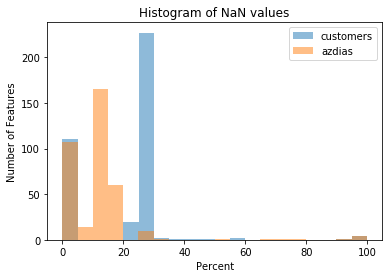

In [127]:
bins = 20

plt.hist(customers_perc, bins, alpha=0.5, label='customers')
plt.hist(azdias_perc, bins, alpha=0.5, label='azdias')
plt.legend(loc='upper right')
plt.title("Histogram of NaN values")
plt.xlabel("Percent")
plt.ylabel("Number of Features")
plt.show()

Typically if a feature has between 20-30% nan values then it's best to drop it from the dataset. Interestingly the customers dataset has features with a higher percentage of missing values than the azdias. Since there is over 200 features with between 25-30% nan values, we'll set the limit at 30%. 

To keep the same features in both datasets we'll extract the column names with less than 30% nan features and then drop them from both datasets.

In [136]:
# columns to drop
columns_dropped = azdias_perc[azdias_perc > 30].index.tolist()
columns_dropped

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [137]:
azdias.drop(columns=columns_dropped, inplace=True)
customers.drop(columns=columns_dropped, inplace=True)

In [138]:
print(f'Customer features: {customers.shape[1]}')
print(f'Azdias features: {azdias.shape[1]}')

Customer features: 359
Azdias features: 356


In [140]:
print(f'Total columns dropped: {len(columns_dropped)}')

Total columns dropped: 10


#### Rows to drop

In [141]:
%%time
customers_perc_rows = percent_of_nan(customers, 1)
azdias_perc_rows = percent_of_nan(azdias, 1)

CPU times: user 9.93 s, sys: 6.58 s, total: 16.5 s
Wall time: 5min 15s


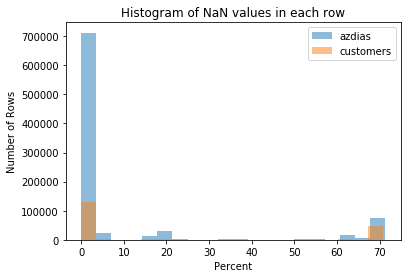

In [142]:
plt.hist(azdias_perc_rows, bins, alpha=0.5, label='azdias')
plt.hist(customers_perc_rows, bins, alpha=0.5, label='customers')
plt.legend(loc='upper right')
plt.title("Histogram of NaN values in each row")
plt.xlabel("Percent")
plt.ylabel("Number of Rows")
plt.show()

Again I think 30% will be a good cut-off for the percent of nan values in each row. It looks like there's a lot of rows that have over 60% of values that are nan. The customers dataframe looks to have a much higher ratio of these.

In [150]:
%%time
customers = customers.loc[customers_perc_rows[customers_perc_rows <= 30].index, :].copy()
azdias = azdias.loc[azdias_perc_rows[azdias_perc_rows <= 30].index, :].copy()

CPU times: user 5.53 s, sys: 13.2 s, total: 18.8 s
Wall time: 9min 23s


In [151]:
print(f'Azdias Number of Rows: {azdias.shape[0]}')
print(f'Azdias Number of Columns: {azdias.shape[1]}')
print(f'Customers Number of Rows: {customers.shape[0]}')
print(f'Customers Number of Columns: {customers.shape[1]}')

Azdias Number of Rows: 785420
Azdias Number of Columns: 356
Customers Number of Rows: 140371
Customers Number of Columns: 359


### Processsing Each Feature

We can now look at the two columns we were warned about when loading the csv files, since they weren't deleted based on number of nan values

In [154]:
azdias['CAMEO_DEUG_2015'].value_counts().index

Index(['8', '9', '6', '4', 8.0, '3', '2', 9.0, '7', 6.0, 4.0, 3.0, 2.0, 7.0,
       '5', 5.0, '1', 1.0, 'X'],
      dtype='object')

CAMEO_DEUG_2015 has interger, float and string values. We just want numbers 1 through 9 so we'll remove the X values and change all to float

In [156]:
def CAMEO_DEUG_2015_processing(df):
    """
    Drops rows with values 'X', changes type to float
    
    Attr:
        df (DataFrame) : DataFrame to be processed
        
    Returns:
        df (DataFrame) : DataFrame with two newly created columns and one orginal dropped.
    """
    
    df = df.loc[df['CAMEO_DEUG_2015'] != "X"].copy()
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    return df   

In [157]:
customers = CAMEO_DEUG_2015_processing(customers)
azdias = CAMEO_DEUG_2015_processing(azdias)

In [155]:
azdias['CAMEO_INTL_2015'].value_counts().index

Index(['51', 51.0, '41', '24', 41.0, 24.0, '14', '43', 14.0, '54', 43.0, '25',
       54.0, '22', 25.0, '23', '13', '45', 22.0, '55', '52', 13.0, 45.0, 23.0,
       '31', '34', 55.0, '15', 52.0, '44', 31.0, 34.0, '12', 15.0, 44.0, '35',
       '32', '33', 12.0, 32.0, 35.0, 33.0, 'XX'],
      dtype='object')

CAMEO_INTL_2015 doesn't match an Attribute in the excel DIAS Attribute - Values file. There is however a CAMEO_DEUINTL_2015, where the data looks very similar to these values. Instead of simply dropping this feature we'll assume the values match CAMEO_DEUINTL_2015.

In [158]:
def CAMEO_INTL_2015_processing(df):
    """
    Looks to match CAMEO_DEUINTL_2015 in DIAS Attributes. 
    splits the column into two by using the first and second digits
    to denote the family home type and level of household wealth (affluency)
    
    Attr:
        df (DataFrame) : DataFrame to be processed
        
    Returns:
        df (DataFrame) : DataFrame with two newly created columns and one orginal dropped.
    """
    
    df = df.loc[df['CAMEO_INTL_2015'] != "XX"].copy()
    df['AFFLUENCY'] = df['CAMEO_INTL_2015'].str[:1].astype(float)
    df['FAMILY_TYPE'] = df['CAMEO_INTL_2015'].str[1:2].astype(float)
    df.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    return df

In [159]:
customers = CAMEO_INTL_2015_processing(customers)
azdias = CAMEO_INTL_2015_processing(azdias)

#### Features not referenced in DIAS Attributes - Values

In [160]:
%%time
customers.to_csv("customers_dropped_nans.csv", index=False)
azdias.to_csv("azdias_dropped_nans.csv", index=False)

CPU times: user 4min 9s, sys: 1.97 s, total: 4min 10s
Wall time: 4min 33s


In [2]:
%%time

# CHECKPOINT SAVE/LOAD PROGRESS

# SAVE
#customers.to_csv("customers_dropped_nans.csv", index=False)
#azdias.to_csv("azdias_dropped_nans.csv", index=False)

# LOAD
azdias = pd.read_csv('azdias_dropped_nans.csv')
customers = pd.read_csv('customers_dropped_nans.csv')

attr_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
attribute_desc = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

CPU times: user 52.2 s, sys: 12.3 s, total: 1min 4s
Wall time: 6min 18s


In [3]:
%%time
azdias = pd.read_csv('azdias_dropped_nans.csv')
customers = pd.read_csv('customers_dropped_nans.csv')

CPU times: user 57.9 s, sys: 13.5 s, total: 1min 11s
Wall time: 10min 59s


In [4]:
# get a list of all the attributes that are mentioned in the DIAS Attributes Excel file
DIAS_attributes = attr_values.Attribute.value_counts().index.tolist()

In [11]:
unlabled_attributes = []
for column in azdias.columns:
    if column not in DIAS_attributes:
        unlabled_attributes.append(column)

In [24]:
# value_counts doesn't include nan values which is the preferred reason to using unique()
attribute_name = []
n_unique_values = []
unique_values = []

for column in azdias.columns:
    attribute_name.append(column)
    n_unique_values.append(len(azdias[column].value_counts().index))
    unique_values.append(azdias[column].value_counts().index.tolist())
    
attribute_info = pd.DataFrame({'ATTRIBUTE':attribute_name,
                              'NUM_VALUES':n_unique_values,
                              'VALUES':unique_values})

We'll create a DataFrame that holds the number of unique values.

In [29]:
attribute_info[attribute_info.NUM_VALUES > 10]

,ATTRIBUTE,NUM_VALUES,VALUES
0,LNR,785073,"[1050623, 1004864, 986443, 984394, 988488, 100..."
2,ALTERSKATEGORIE_FEIN,26,"[15.0, 14.0, 16.0, 18.0, 17.0, 13.0, 12.0, 19...."
3,ANZ_HAUSHALTE_AKTIV,292,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."
4,ANZ_HH_TITEL,20,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 7.0, ..."
5,ANZ_KINDER,11,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, ..."
6,ANZ_PERSONEN,29,"[1.0, 2.0, 3.0, 4.0, 0.0, 5.0, 6.0, 7.0, 8.0, ..."
7,ANZ_STATISTISCHE_HAUSHALTE,263,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."
11,CAMEO_DEU_2015,44,"[6B, 8A, 4C, 2D, 3C, 7A, 3D, 8B, 4A, 8C, 9D, 9..."
29,D19_BANKEN_ONLINE_QUOTE_12,11,"[0.0, 10.0, 5.0, 3.0, 7.0, 8.0, 9.0, 6.0, 2.0,..."
46,D19_GESAMT_ONLINE_QUOTE_12,11,"[0.0, 10.0, 5.0, 8.0, 7.0, 9.0, 3.0, 6.0, 2.0,..."


In [23]:
azdias.ANZ_HH_TITEL.unique()[3]

nan

In [23]:
customers['D19_TELKO_ONLINE_QUOTE_12'].value_counts()

0.0     139029
10.0       183
5.0          3
3.0          1
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: int64

In [172]:
azdias['CJT_TYP_5'].value_counts()

5.0    209112
3.0    181482
2.0    162797
4.0    135369
1.0     91632
Name: CJT_TYP_5, dtype: int64

In [211]:
unexplained_features = []
for i in a:
    if i not in b:
        unexplained_features.append(i)

In [286]:
values = []
for i in unexplained_features:

    values.append(customers[i].value_counts().sort_values().index.tolist())


df = pd.DataFrame({"FEATURE": unexplained_features, 
                   "VALUES": values,
                  "NUM_VALUES": [len(x) for x in values]})
df[df.NUM_VALUES > 10].sort_values(by='NUM_VALUES', ascending=False)

,FEATURE,VALUES,NUM_VALUES
57,EINGEFUEGT_AM,"[2010-06-28 00:00:00, 2004-12-02 00:00:00, 200...",3034
4,ANZ_STATISTISCHE_HAUSHALTE,"[186.0, 144.0, 116.0, 130.0, 201.0, 274.0, 168...",214
82,VERDICHTUNGSRAUM,"[40.0, 37.0, 41.0, 26.0, 43.0, 30.0, 39.0, 22....",46
6,CAMEO_INTL_2015,"[XX, 52.0, 33.0, 32.0, 35.0, 31.0, 44.0, 52, 5...",43
58,EINGEZOGENAM_HH_JAHR,"[1986.0, 1987.0, 2017.0, 1988.0, 2018.0, 1989....",33
2,ALTERSKATEGORIE_FEIN,"[3.0, 2.0, 23.0, 4.0, 22.0, 25.0, 24.0, 21.0, ...",25
86,VK_DISTANZ,"[13.0, 12.0, 11.0, 10.0, 9.0, 5.0, 8.0, 7.0, 2...",13
85,VK_DHT4A,"[11.0, 8.0, 9.0, 10.0, 5.0, 6.0, 4.0, 7.0, 3.0...",11
87,VK_ZG11,"[10.0, 11.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0...",11


In [287]:
# UNLABLED FEATURES WITH OVER TEN UNIQUE VALUES

# LNR (unique values) - DROP
# D19_LETZTER_KAUF_BRANCHE - (Last category of spending) - DROP
# EINGEFUEGT_AM (inserted on) - DROP
# ANZ_STATISTISCHE_HAUSHALTE (statistical budgets) - DROP
# VERDICHTUNGSRAUM (compression area) - DROP
# CAMEO_INTL_2015 (???) - DROP
# EINGEZOGENAM_HH_JAHR - (Recovered at HH year) - DATETIME
# ALTERSKATEGORIE_FEIN - (Age category fine) - DROP
# VK_DISTANZ (VK distance) - DROP
# VK_DHT4A (???) - DROP
# VK_ZG11 (???) - DROP

In [36]:
customers.drop(columns=['LNR', 'D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'ANZ_STATISTISCHE_HAUSHALTE', 'VERDICHTUNGSRAUM',
                       'ALTERSKATEGORIE_FEIN', 'VK_DISTANZ', 'VK_DHT4A', 'VK_ZG11'], inplace=True)
azdias.drop(columns=['LNR', 'D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'ANZ_STATISTISCHE_HAUSHALTE', 'VERDICHTUNGSRAUM',
                       'ALTERSKATEGORIE_FEIN', 'VK_DISTANZ', 'VK_DHT4A', 'VK_ZG11'], inplace=True)

Looking at features with more than 10 unique values it's clear we need to drop LNR as there is no reference to what this is and whether it's categorical or not. Therefore we'll remove it.

D19_LETZTER_KAUF_BRANCHE refers to last category of spending. It could be possible to shorten the categorical features futher but as of now I'll remove them.

In [249]:
attr_value_count = attr_values.fillna(method='ffill').groupby('Attribute')['Meaning'].count()
top_attr_values = attr_value_count[attr_value_count > 10].sort_values(ascending=False)
top_attr_values

Attribute
CAMEO_DEU_2015                 44
LP_LEBENSPHASE_FEIN            40
CAMEO_DEUINTL_2015             26
ALTER_HH                       22
PRAEGENDE_JUGENDJAHRE          16
LP_LEBENSPHASE_GROB            12
GFK_URLAUBERTYP                12
LP_FAMILIE_GROB                11
LP_FAMILIE_FEIN                11
D19_VERSAND_ONLINE_QUOTE_12    11
D19_GESAMT_ONLINE_QUOTE_12     11
D19_BANKEN_ONLINE_QUOTE_12     11
Name: Meaning, dtype: int64

In [255]:
values = []
for i in customers.columns:
    values.append(customers[i].value_counts().sort_values().index.tolist())

df = pd.DataFrame({"FEATURE": customers.columns, 
                   "VALUES": values,
                  "NUM_VALUES": [len(x) for x in values]})
df[(df.NUM_VALUES > 10) & ~(df.FEATURE.isin(unexplained_features))].sort_values(by='NUM_VALUES', ascending=False)

,FEATURE,VALUES,NUM_VALUES
185,KBA13_ANZAHL_PKW,"[77.0, 15.0, 13.0, 11.0, 31.0, 34.0, 8.0, 48.0...",1250
4,ANZ_HAUSHALTE_AKTIV,"[186.0, 148.0, 367.0, 179.0, 172.0, 126.0, 276...",216
104,GEBURTSJAHR,"[1902, 1908, 1909, 2010, 2009, 2006, 1900, 201...",113
12,CAMEO_DEU_2015,"[XX, 6A, 7D, 5E, 9B, 9C, 9A, 7E, 5F, 1B, 6F, 7...",45
299,LP_LEBENSPHASE_FEIN,"[21.0, 22.0, 3.0, 4.0, 29.0, 24.0, 14.0, 1.0, ...",41
303,MIN_GEBAEUDEJAHR,"[2016.0, 1985.0, 1986.0, 2015.0, 1987.0, 2014....",32
2,ALTER_HH,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 13.0, 19.0, 14....",20
5,ANZ_HH_TITEL,"[12.0, 15.0, 18.0, 23.0, 10.0, 20.0, 11.0, 14....",20
13,CAMEO_DEUG_2015,"[X, 9.0, 7.0, 5.0, 8.0, 1.0, 6.0, 9, 3.0, 4.0,...",19
7,ANZ_PERSONEN,"[15.0, 16.0, 21.0, 13.0, 14.0, 12.0, 11.0, 10....",18


In [264]:
# ANZ_HH_TITEL - how many people hold an academic title in the household
customers['ANZ_HH_TITEL'] = np.where(customers['ANZ_HH_TITEL']>=3,3.0,customers['ANZ_HH_TITEL'])

In [265]:
# KBA13_ANZAHL_PKW - number of cars - CONTINUOUS

0.0    133451
1.0      5186
2.0       459
3.0       443
Name: ANZ_HH_TITEL, dtype: int64

In [ ]:
# FEATURES WITH OVER TEN UNIQUE VALUES

# KBA13_ANZAHL_PKW - number of cars in the PLZ8 - CONTINUOUS
# ANZ_HAUSHALTE_AKTIV - number of households in building - DROP
# GEBURTSJAHR - DOB - CONTINUOUS
# CAMEO_DEU_2015 - cat - DROP
# MIN_GEBAEUDEJAHR - year household mentioned in database - DROP
# ALTER_HH - main age of household - DROP
# ANZ_HH_TITEL - number of holders of academic titles in building - DROP
# CAMEO_DEUG_2015 - wrong value types
# ANZ_PERSONEN - number adults in household - GROUP
# LP_FAMILIE_FEIN - DROP
# D19_GESAMT_ONLINE_QUOTE_12 - DROP
# D19_VERSAND_ONLINE_QUOTE_12 - DROP

In [37]:
customers.drop(columns=['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEU_2015', 'MIN_GEBAEUDEJAHR', 'ALTER_HH', 'ANZ_HH_TITEL',
                       'ANZ_PERSONEN','CAMEO_DEUG_2015', 'LP_FAMILIE_FEIN', 'D19_GESAMT_ONLINE_QUOTE_12'
                       ,'D19_VERSAND_ONLINE_QUOTE_12'], inplace=True)
azdias.drop(columns=['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEU_2015', 'MIN_GEBAEUDEJAHR', 'ALTER_HH', 'ANZ_HH_TITEL',
                       'ANZ_PERSONEN','CAMEO_DEUG_2015', 'LP_FAMILIE_FEIN', 'D19_GESAMT_ONLINE_QUOTE_12'
                       ,'D19_VERSAND_ONLINE_QUOTE_12'], inplace=True)

In [278]:
customers['LP_FAMILIE_FEIN'].value_counts()

1.0     38622
10.0    33811
2.0     27331
11.0    20860
0.0      6274
8.0      4402
7.0      2775
9.0      2261
5.0       831
6.0       772
4.0       520
3.0       142
Name: LP_FAMILIE_FEIN, dtype: int64

In [38]:
customers.shape

(141596, 345)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [44]:
import clean_data as cdf

In [99]:
cdf.messitup(customers)

"what's up"

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')